In [1]:
%matplotlib inline

In [2]:
import numpy as np

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [5]:
from torch.utils.tensorboard import SummaryWriter

In [4]:
%load_ext tensorboard

In [11]:
transform = transforms.Compose(
    [transforms.Resize((64, 64)), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [12]:
face_data = torchvision.datasets.ImageFolder(root = '../data/face_age/', transform = transform)

In [13]:
face_data.target_transform = lambda id: float(face_data.classes[id])

In [14]:
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

image_range = list(range(len(face_data.imgs)))

train, test = train_test_split(image_range, test_size=.3)
valid, test = train_test_split(test, test_size=.3)

In [15]:
len(train), len(valid), len(test)

(6844, 2053, 881)

In [16]:
#BATCH SIZE
train_face_loader = torch.utils.data.DataLoader(face_data, batch_size=4, num_workers=4, 
                                                sampler=SubsetRandomSampler(train))
valid_face_loader = torch.utils.data.DataLoader(face_data, batch_size=4, num_workers=4, 
                                                sampler=SubsetRandomSampler(valid))
test_face_loader = torch.utils.data.DataLoader(face_data, batch_size=4, num_workers=4, 
                                               sampler=SubsetRandomSampler(test))

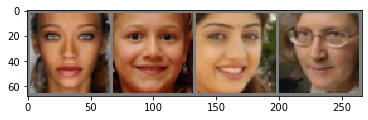

In [17]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_face_loader)
images, labels = dataiter.next()

# show images
out = torchvision.utils.make_grid(images)
imshow(out)

In [18]:
labels

tensor([22.,  8., 21., 58.], dtype=torch.float64)

In [19]:
# classification (2 class ) - 1 out - 1 or 0 - nn.NLLLoss or nn.BCELoss
# classification (>2 class ) - n class out - [(1 or 0), (1 or 0), ... n] - CrossEntropyLoss
# regression 1 out - criteria - regressional - MSELoss

In [21]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()#64*64
        self.conv1 = nn.Conv2d(3, 6, 5)#60*60
        #self.batch1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)#30*30
        self.conv2 = nn.Conv2d(6, 16, 5)#26*26 - #13*13
        #self.batch2 = nn.BatchNorm2d(16)
        #self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        #self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 84)
        #self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.batch1(x)
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.batch2(x)
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        #x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout2(x)
        x = self.fc3(x)
        return x


net = Net()

In [22]:
for parameter in net.parameters():
    print(parameter.data.shape)

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 2704])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([1, 84])
torch.Size([1])


In [23]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
device

device(type='cpu')

In [34]:
## default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('./boards/exp2')

In [42]:
train_cases = 0
test_cases = 0
best_metric = 9999
best_epoch = 0
PATH = './face_regr.pth'
for epoch in range(5):  # loop over the dataset multiple times
    train_mse=0
    train_mae=0
    train_cases = 0  
    valid_mse=0
    valid_mae=0
    test_cases = 0
    for i, data in enumerate(train_face_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        net.train()
        with torch.set_grad_enabled(True):
            inputs, labels = data
            inputs = inputs.float()
            labels = labels.float()
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())
            outputs = torch.reshape(outputs, (-1,))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            train_mse += loss.item()
            train_mae += sum(abs(list(outputs.detach().numpy())-labels.numpy()))
            train_cases += len(labels.numpy())
        if i % 200 == 199:    # print every 2000 mini-batches
            # ...log the running loss
            writer.add_scalar('training loss',
                            train_mse / train_cases,
                            epoch * len(train_face_loader) + i)
    for k, data in enumerate(valid_face_loader, 0):
        with torch.no_grad():
            images, labels = data
            net.eval()
            outputs = net(images)
            outputs = torch.reshape(outputs, (-1,))

            valid_mae += sum(abs(list(outputs.detach().numpy())-labels.numpy()))
            valid_mse += sum(np.square(list(outputs.detach().numpy())-labels.numpy()))
            test_cases += len(labels.numpy())
    writer.add_scalar('test loss',
                       valid_mse/test_cases,
                        epoch * len(train_face_loader) + i)
    print(f'Epoch # {epoch}:', 
          '\t', f'train_mae {round(train_mae/train_cases, 2)} ',f'valid_mae {round(valid_mae/test_cases, 2)}',
          '\t', f'train_mse {round(train_mse/train_cases, 2)} ',f'valid_mse {round(valid_mse/test_cases, 2)}')
    #callback best model
    if valid_mae/test_cases<best_metric:
        best_metric = valid_mae/test_cases
        best_epoch = epoch
        torch.save(net.state_dict(), PATH)
    
    # early stopping  
    if epoch - best_epoch>3:
        break
        
print('Finished Training')

Epoch # 0: 	 train_mae 5.7  valid_mae 7.8 	 train_mse 16.62  valid_mse 142.61
Epoch # 1: 	 train_mae 5.37  valid_mae 7.26 	 train_mse 14.73  valid_mse 126.22
Epoch # 2: 	 train_mae 4.94  valid_mae 7.35 	 train_mse 12.5  valid_mse 134.99
Epoch # 3: 	 train_mae 4.65  valid_mae 7.52 	 train_mse 10.9  valid_mse 133.6
Epoch # 4: 	 train_mae 4.19  valid_mae 7.13 	 train_mse 8.79  valid_mse 123.19
Finished Training


In [40]:
writer.add_graph(net, images)

In [41]:
%tensorboard --logdir boards

In [43]:
writer.close()